In [2]:
import pandas as pd
import networkx as nx
import os
import configparser
import itertools
import json

In [3]:
config = configparser.ConfigParser()
config.read('rules.ini')

settings = {}
settings['path'] = config['RULES']['path']
settings['variation'] = config['RULES']['variation'][0]
settings['prop_variation'] = float(config['RULES']['variation'][1:])

In [4]:
path = r'C:\DanielBaron\GenerativeLSTM\output_files\20230417_3E8ABBDA_765B_4740_A305_D925CF5DE07C'
org_log_path = os.path.join(path, 'parameters', 'original_log.csv')

df_org = pd.read_csv(org_log_path)
df_org['start_timestamp'] = pd.to_datetime(df_org['start_timestamp'])
df_org['end_timestamp'] = pd.to_datetime(df_org['end_timestamp'])
df_org['rank'] = df_org.groupby('caseid')['start_timestamp'].rank().astype(int)

In [5]:
ac_index = dict(zip(df_org.task, df_org.ac_index))

In [6]:
path = r'C:\DanielBaron\GenerativeLSTM\output_files\20230417_3E8ABBDA_765B_4740_A305_D925CF5DE07C'
gen_log_path = os.path.join(path, 'parameters', 'generated_log.csv')

df_gen = pd.read_csv(gen_log_path)
df_gen['start_timestamp'] = pd.to_datetime(df_gen['start_timestamp'])
df_gen['end_timestamp'] = pd.to_datetime(df_gen['end_timestamp'])
df_gen['rank'] = df_gen.groupby('caseid')['start_timestamp'].rank().astype(int)

In [7]:
act_paths = list(itertools.product(*[x if type(x) is list else [x] for x in [json.loads(x.strip()) for x in settings['path'].split('>>')] ]))
act_paths_idx = [(ac_index[x[0]], ac_index[x[1]]) for x in act_paths]

## Add edges

In [11]:
class GenerateStats:
    def __init__(self, log, ac_index, ac_paths) -> None:
        self.log = log
        self.log['start_timestamp'] = pd.to_datetime(self.log['start_timestamp'])
        self.log['end_timestamp'] = pd.to_datetime(self.log['end_timestamp'])
        self.log['rank'] = self.log.groupby('caseid')['start_timestamp'].rank().astype(int)
        self.ac_index = ac_index
        self.ac_paths = ac_paths

    def evaluate_condition(self, df_case):
        df_case = df_case.sort_values(by='rank')
        u_tasks = [self.ac_index[x] for x in df_case['task'].drop_duplicates()]
        
        G = nx.DiGraph()
        for task in u_tasks:
            G.add_node(task)

        tasks = list(df_case['task'])
        if list(df_case['rank']) == list(set(list(df_case['rank']))):
            order = [(self.ac_index[x[0]], self.ac_index[x[1]]) for x in [(a, b) for a, b in zip(tasks[:-1], tasks[1:])]]
        else:
            order = []
            for i in range(1, len(df_case['rank'])):
                c_task = list(df_case[df_case['rank']==i]['task'])
                n_task = list(df_case[df_case['rank']==i+1]['task'])
                order += [(self.ac_index[x[0]], self.ac_index[x[1]]) for x in list(itertools.product(c_task, n_task))]

        G.add_edges_from(order)
        conds = [nx.is_simple_path(G, act_path) for act_path in act_paths_idx]

        return min(conds)

    def get_stats(self):

        pos_cases = 0
        total_cases = len(self.log['caseid'].drop_duplicates())
        for caseid in self.log['caseid'].drop_duplicates():

            df_case = self.log[self.log['caseid']==caseid]
            cond = self.evaluate_condition(df_case)
            if cond:
                pos_cases += 1

        return pos_cases, total_cases

In [12]:
gs = GenerateStats(df_org, ac_index, act_paths_idx)

In [41]:
from pandas import Timestamp
from support_modules import traces_evaluation as te

In [57]:
settings = te.extract_rules()
settings

{'path': '"Final Inspection Q.C." >> "Round Grinding"',
 'variation': '+',
 'prop_variation': 0.1,
 'act_paths': [('Final Inspection Q.C.', 'Round Grinding')]}

In [58]:
trace = [{'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 00:00:00'), 'end_timestamp': Timestamp('2012-03-13 02:09:16'), 'dur_raw': 0.09367651, 'dur': 7756.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 02:09:16'), 'end_timestamp': Timestamp('2012-03-13 04:09:57'), 'dur_raw': 0.08744754, 'dur': 7241.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 04:09:57'), 'end_timestamp': Timestamp('2012-03-13 06:00:14'), 'dur_raw': 0.07991026, 'dur': 6617.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 06:00:14'), 'end_timestamp': Timestamp('2012-03-13 07:39:38'), 'dur_raw': 0.07202387, 'dur': 5964.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 07:39:38'), 'end_timestamp': Timestamp('2012-03-13 09:10:13'), 'dur_raw': 0.06563606, 'dur': 5435.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 09:10:13'), 'end_timestamp': Timestamp('2012-03-13 10:34:54'), 'dur_raw': 0.061369464, 'dur': 5081.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 10:34:54'), 'end_timestamp': Timestamp('2012-03-13 12:01:25'), 'dur_raw': 0.06269527, 'dur': 5191.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 12:01:25'), 'end_timestamp': Timestamp('2012-03-13 13:29:51'), 'dur_raw': 0.06408131, 'dur': 5306.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 13:29:51'), 'end_timestamp': Timestamp('2012-03-13 14:59:43'), 'dur_raw': 0.065124825, 'dur': 5392.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 14:59:43'), 'end_timestamp': Timestamp('2012-03-13 16:30:17'), 'dur_raw': 0.06562811, 'dur': 5434.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-13 16:30:17'), 'end_timestamp': Timestamp('2012-03-13 18:00:53'), 'dur_raw': 0.06565593, 'dur': 5436.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 18:00:53'), 'end_timestamp': Timestamp('2012-03-13 19:31:07'), 'dur_raw': 0.06538925, 'dur': 5414.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 3', 'start_timestamp': Timestamp('2012-03-13 19:31:07'), 'end_timestamp': Timestamp('2012-03-13 21:01:06'), 'dur_raw': 0.06520532, 'dur': 5399.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-13 21:01:06'), 'end_timestamp': Timestamp('2012-03-13 22:30:58'), 'dur_raw': 0.06512189, 'dur': 5392.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling Q.C.', 'role': 'end', 'start_timestamp': Timestamp('2012-03-13 22:30:58'), 'end_timestamp': Timestamp('2012-03-14 00:00:50'), 'dur_raw': 0.065116175, 'dur': 5392.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Final Inspection Q.C.', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 00:00:50'), 'end_timestamp': Timestamp('2012-03-14 01:30:44'), 'dur_raw': 0.065147564, 'dur': 5394.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 1', 'start_timestamp': Timestamp('2012-03-14 01:30:44'), 'end_timestamp': Timestamp('2012-03-14 03:00:41'), 'dur_raw': 0.06518093, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 03:00:41'), 'end_timestamp': Timestamp('2012-03-14 04:30:39'), 'dur_raw': 0.06519602, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 04:30:39'), 'end_timestamp': Timestamp('2012-03-14 06:00:37'), 'dur_raw': 0.065197736, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Lapping', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 06:00:37'), 'end_timestamp': Timestamp('2012-03-14 07:30:35'), 'dur_raw': 0.06519316, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 07:30:35'), 'end_timestamp': Timestamp('2012-03-14 09:00:33'), 'dur_raw': 0.06518809, 'dur': 5398.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 09:00:33'), 'end_timestamp': Timestamp('2012-03-14 10:30:30'), 'dur_raw': 0.06518525, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Round Grinding', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 10:30:30'), 'end_timestamp': Timestamp('2012-03-14 12:00:27'), 'dur_raw': 0.06518478, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Lapping', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 12:00:27'), 'end_timestamp': Timestamp('2012-03-14 13:30:24'), 'dur_raw': 0.06518542, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Flat Grinding', 'role': 'Role 7', 'start_timestamp': Timestamp('2012-03-14 13:30:24'), 'end_timestamp': Timestamp('2012-03-14 15:00:21'), 'dur_raw': 0.06518625, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Lapping', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 15:00:21'), 'end_timestamp': Timestamp('2012-03-14 16:30:18'), 'dur_raw': 0.06518671, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Packing', 'role': 'Role 10', 'start_timestamp': Timestamp('2012-03-14 16:30:18'), 'end_timestamp': Timestamp('2012-03-14 18:00:15'), 'dur_raw': 0.065186836, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Final Inspection Q.C.', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 18:00:15'), 'end_timestamp': Timestamp('2012-03-14 19:30:12'), 'dur_raw': 0.06518674, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Packing', 'role': 'Role 2', 'start_timestamp': Timestamp('2012-03-14 19:30:12'), 'end_timestamp': Timestamp('2012-03-14 21:00:09'), 'dur_raw': 0.06518663, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}, {'caseid': 'Case43', 'task': 'Turning & Milling', 'role': 'end', 'start_timestamp': Timestamp('2012-03-14 21:00:09'), 'end_timestamp': Timestamp('2012-03-14 22:30:06'), 'dur_raw': 0.06518653, 'dur': 5397.0, 'wait_raw': 0, 'wait': 0.0}]

In [64]:
ac_index

{'Turning & Milling': 21,
 'Turning & Milling Q.C.': 22,
 'Laser Marking': 8,
 'Lapping': 7,
 'Round Grinding': 15,
 'Final Inspection Q.C.': 3,
 'Packing': 12,
 'Turning Q.C.': 23,
 'Flat Grinding': 5,
 'Grinding Rework': 6,
 'Setup': 17,
 'Turning': 20,
 'SETUP     Turning & Milling': 16,
 'Final Inspection': 2,
 'Rework Milling': 13,
 'Milling Q.C.': 10,
 'Milling': 9,
 'Fix': 4,
 'Round  Q.C.': 14,
 'Stress Relief': 18,
 'Turning Rework': 24,
 'Change Version': 1,
 'Turn & Mill. & Screw Assem': 19,
 'Nitration Q.C.': 11}

In [63]:
act_paths_idx = [(ac_index[x[0]], ac_index[x[1]]) for x in settings['act_paths']]
act_paths_idx

[(3, 15)]

In [60]:
df_case = pd.DataFrame.from_records(trace, index=list(trace[0].keys())).reset_index()
df_case['rank'] = df_case.groupby('caseid')['start_timestamp'].rank().astype(int)
df_case

,caseid,task,role,start_timestamp,end_timestamp,dur_raw,dur,wait_raw,wait,rank
0,Case43,Turning & Milling,Role 1,2012-03-13 00:00:00,2012-03-13 02:09:16,0.093677,7756.0,0,0.0,1
1,Case43,Turning & Milling,Role 1,2012-03-13 02:09:16,2012-03-13 04:09:57,0.087448,7241.0,0,0.0,2
2,Case43,Turning & Milling,Role 1,2012-03-13 04:09:57,2012-03-13 06:00:14,0.079910,6617.0,0,0.0,3
3,Case43,Turning & Milling Q.C.,Role 3,2012-03-13 06:00:14,2012-03-13 07:39:38,0.072024,5964.0,0,0.0,4
4,Case43,Turning & Milling,Role 3,2012-03-13 07:39:38,2012-03-13 09:10:13,0.065636,5435.0,0,0.0,5
5,Case43,Turning & Milling Q.C.,Role 3,2012-03-13 09:10:13,2012-03-13 10:34:54,0.061369,5081.0,0,0.0,6
6,Case43,Turning & Milling,Role 1,2012-03-13 10:34:54,2012-03-13 12:01:25,0.062695,5191.0,0,0.0,7
7,Case43,Turning & Milling,Role 1,2012-03-13 12:01:25,2012-03-13 13:29:51,0.064081,5306.0,0,0.0,8
8,Case43,Turning & Milling,Role 1,2012-03-13 13:29:51,2012-03-13 14:59:43,0.065125,5392.0,0,0.0,9
9,Case43,Turning & Milling Q.C.,Role 1,2012-03-13 14:59:43,2012-03-13 16:30:17,0.065628,5434.0,0,0.0,10


In [61]:
df_case = df_case.sort_values(by='rank')
u_tasks = [ac_index[x] for x in df_case['task'].drop_duplicates()]

G = nx.DiGraph()
for task in u_tasks:
    G.add_node(task)

tasks = list(df_case['task'])
if list(df_case['rank']) == list(set(list(df_case['rank']))):
    order = [(ac_index[x[0]], ac_index[x[1]]) for x in [(a, b) for a, b in zip(tasks[:-1], tasks[1:])]]
    print(1)
else:
    order = []
    for i in range(1, len(df_case['rank'])):
        c_task = list(df_case[df_case['rank']==i]['task'])
        n_task = list(df_case[df_case['rank']==i+1]['task'])
        order += [(ac_index[x[0]], ac_index[x[1]]) for x in list(itertools.product(c_task, n_task))]
    print(2)
G.add_edges_from(order)
conds = [nx.is_simple_path(G, act_path) for act_path in act_paths_idx]

1


## Prueba Union Simod

In [18]:
from bs4 import BeautifulSoup

path_asis = r'Simod-Coral-Version\outputs\20230417_84C5DFCD_FF3E_415F_A9ED_104A01FFB164\Production_ASIS.bpmn'

with open(path_asis, 'r') as f:
    data_asis = f.read()

bpmn_asis = BeautifulSoup(data_asis, "xml") 
sim_info_asis = str(bpmn_asis.find_all('qbp:processSimulationInfo')[0])
att_info_asis = data_asis.replace(sim_info_asis, '')

In [19]:
path_tobe = r'Simod-Coral-Version\outputs\20230417_84C5DFCD_FF3E_415F_A9ED_104A01FFB164\Production_TOBE.bpmn'

with open(path_tobe, 'r') as f:
    data_tobe = f.read()

bpmn_tobe = BeautifulSoup(data_tobe, "xml") 
sim_info_tobe = str(bpmn_tobe.find_all('qbp:processSimulationInfo')[0])
att_info_tobe = data_asis.replace(sim_info_tobe, '')

In [23]:
bpmn_rules_based = '{}\n{}'.format(att_info_tobe, sim_info_asis)

In [26]:
output_path_files = r'Simod-Coral-Version\outputs\20230417_84C5DFCD_FF3E_415F_A9ED_104A01FFB164\Production_RULE_BASED.bpmn'
with open(output_path_files, 'w') as file:
    file.write(bpmn_rules_based)

In [ ]:
def combine_models(model_asis_path, model_tobe_path, rules_model_path):

    with open(model_asis_path, 'r') as f:
        data_asis = f.read()

    bpmn_asis = BeautifulSoup(data_asis, "xml") 
    sim_info_asis = str(bpmn_asis.find_all('qbp:processSimulationInfo')[0])

    with open(model_tobe_path, 'r') as f:
        data_tobe = f.read()

    bpmn_tobe = BeautifulSoup(data_tobe, "xml") 
    sim_info_tobe = str(bpmn_tobe.find_all('qbp:processSimulationInfo')[0])
    att_info_tobe = data_asis.replace(sim_info_tobe, '')

    bpmn_rules_based = '{}\n{}'.format(att_info_tobe, sim_info_asis)

    with open(output_path_files, 'w') as file:
        file.write(rules_model_path)

## Extract rules

In [1]:
import pandas as pd
import networkx as nx
import os
import configparser
import itertools
import json

In [41]:
config = configparser.ConfigParser()
config.read('rules.ini')

settings = {}
settings['path'] = [x.strip() for x in config['RULES']['path'].split('>>')]
settings['variation'] = config['RULES']['variation'][0] if 'variation' in config.options('RULES') else None
settings['prop_variation'] = float(config['RULES']['variation'][1:]) if 'variation' in config.options('RULES') else None

if '*' in settings['path']:
    settings['rule'] = 'eventually'
elif '^' in settings['path']:
    settings['rule'] = 'not_allowed'
elif '>>' in settings['path'] and '*' not in settings['path'] and '^' not in settings['path']:
    settings['rule'] = 'directly'
elif '>>' not in settings['path'] and '*' not in settings['path'] and '^' not in settings['path']:
    settings['rule'] = 'required'

In [42]:
settings['path'] 

['Turning & Milling Q.C.', '*', 'Lapping']

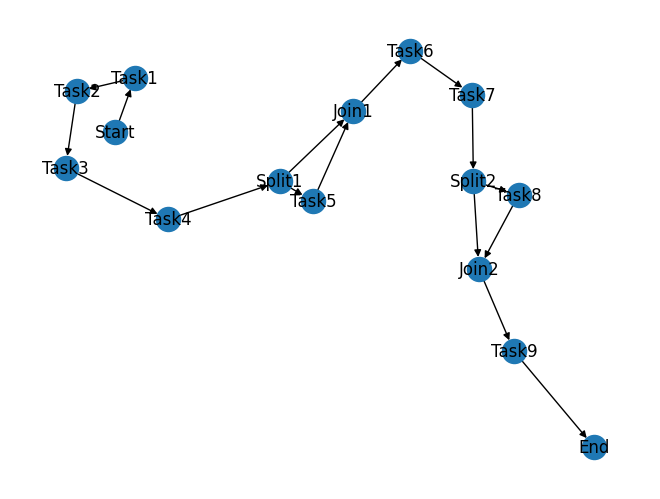

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# create an empty directed graph
G = nx.DiGraph()

# add nodes to the graph
G.add_node('Start')
G.add_node('Task1')
G.add_node('Task2')
G.add_node('Task3')
G.add_node('Task4')
G.add_node('Split1')
G.add_node('Task5')
G.add_node('Join1')
G.add_node('Task6')
G.add_node('Task7')
G.add_node('Split2')
G.add_node('Task8')
G.add_node('Join2')
G.add_node('Task9')
G.add_node('End')

# add edges to the graph
G.add_edge('Start', 'Task1')
G.add_edge('Task1', 'Task2')
G.add_edge('Task2', 'Task3')
G.add_edge('Task3', 'Task4')
G.add_edge('Task4', 'Split1')
G.add_edge('Split1', 'Task5')
G.add_edge('Split1', 'Join1')
G.add_edge('Task5', 'Join1')
G.add_edge('Join1', 'Task6')
G.add_edge('Task6', 'Task7')
G.add_edge('Task7', 'Split2')
G.add_edge('Split2', 'Task8')
G.add_edge('Split2', 'Join2')
G.add_edge('Task8', 'Join2')
G.add_edge('Join2', 'Task9')
G.add_edge('Task9', 'End')

# draw the graph with node labels
nx.draw(G, with_labels=True)
plt.show()

In [2]:
settings['bpmn_path']

'input_files\\bpmn_models\\PurchasingExample.bpmn'

In [1]:
import os
from support_modules import stochastic_model as sm

settings = dict()
settings['timeformat'] = "%Y-%m-%dT%H:%M:%S.%f"
settings['column_names'] = {'Case ID': 'caseid',
                            'Activity': 'task',
                            'lifecycle:transition': 'event_type',
                            'Resource': 'user'}
settings['one_timestamp'] = False
settings['filter_d_attrib'] = True

settings['file'] = 'PurchasingExample'
settings['sm3_path'] = os.path.join('external_tools', 'splitminer3', 'bpmtk.jar')
settings['concurrency'] = 0.0
settings['epsilon'] = 0.5
settings['eta'] = 0.7

settings['log_path'] = os.path.join('input_files', 'event_logs', settings['file'] + '.xes')
settings['tobe_bpmn_path'] = os.path.join('input_files', 'spmd', settings['file'] + '.bpmn')

spmd = sm.StochasticModel(settings)

parsing log, completed traces ::   0%|          | 0/608 [00:00<?, ?it/s]

Rearranging log traces ...      [DONE]
 -- Mining Process Structure --
Loading of bpmn structure from file 100.0%...      [DONE]
Counting branch cases...


100%|██████████| 608/608 [00:00<00:00, 101397.09it/s]


In [2]:
from support_modules import models_merger as mm


settings['bimp_path'] = os.path.join('external_tools', 'bimp', 'qbp-simulator-engine_with_csv_statistics.jar')
settings['asis_bpmn_path'] = os.path.join('input_files', 'simod', settings['file'] + '.bpmn')
settings['csv_output_path'] = os.path.join('output_files', 'simulation_stats', settings['file'] + '.csv')
settings['output_path'] = os.path.join('output_files', 'simulation_files', settings['file'] + '.bpmn')
settings['lrs'] = spmd.lrs

mod_mer = mm.MergeModels(settings)

KeyError: 'csv_output_path'

In [20]:
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import subprocess

asis_bpmn_path = os.path.join('input_files', 'simod', 'PurchasingExample.bpmn')
tobe_bpmn_path = os.path.join('input_files', 'spmd', 'PurchasingExample.bpmn')

asis_tree = ET.parse(asis_bpmn_path)
asis_root = asis_tree.getroot()
tobe_tree = ET.parse(tobe_bpmn_path)
tobe_root = tobe_tree.getroot()
        
namespace = {'bpmn': 'http://www.omg.org/spec/BPMN/20100524/MODEL'}

asis_tasks = asis_root.findall('.//bpmn:task', namespace)
asis_tasks_data = {task.get('id'):task.get('name') for task in asis_tasks}

tobe_tasks = tobe_root.findall('.//bpmn:task', namespace)
tobe_tasks_data = {task.get('name'):task.get('id') for task in tobe_tasks}

In [21]:
with open(asis_bpmn_path, 'r') as f:
    data_asis = f.read()

asis_bpmn_xml = BeautifulSoup(data_asis, "xml") 
asis_sim_info = asis_bpmn_xml.find_all('qbp:processSimulationInfo')[0]
asis_elements = asis_sim_info.findAll('element')

for element in asis_elements:
    element_id_asis = element.get('elementId')
    task_asis = asis_tasks_data[element_id_asis]
    if task_asis in tobe_tasks_data.keys():
        element_id_tobe = tobe_tasks_data[task_asis]
        element['elementId'] = element_id_tobe

tobe_root.append(ET.fromstring(str(asis_sim_info)))

In [22]:
# Find the <sequenceFlows> section within <processSimulationInfo>
sequence_flows = asis_sim_info.find('qbp:sequenceFlows')
sequence_flows.decompose()

new_sequence_flows = asis_bpmn_xml.new_tag('qbp:sequenceFlows')

In [24]:
for key_node in spmd.lrs.branching_probs.keys():
    for key_task, value_task in spmd.lrs.branching_probs[key_node].items():
        new_seq_flow = asis_bpmn_xml.new_tag('qbp:sequenceFlow', elementId=key_task, executionProbability=value_task)
        new_sequence_flows.append(new_seq_flow)

In [26]:
print(new_sequence_flows)

<qbp:sequenceFlows><qbp:sequenceFlow elementId="node_3f3d525e-1c92-44d0-b516-e4f604c7a32d" executionProbability="0.63"/><qbp:sequenceFlow elementId="node_6b5ccb79-5dbf-4768-8eb8-a6451ad0df1b" executionProbability="0.37"/><qbp:sequenceFlow elementId="node_e767b295-61d2-4075-b4a7-2dbcaf1bf72b" executionProbability="0.17"/><qbp:sequenceFlow elementId="node_6a441c92-201d-490d-9484-184440a5c564" executionProbability="0.83"/><qbp:sequenceFlow elementId="node_9548e824-bd93-493e-9d32-26a1b71ce930" executionProbability="0.03"/><qbp:sequenceFlow elementId="node_76a98019-8492-43ab-82e7-1108ba27a81e" executionProbability="0.97"/></qbp:sequenceFlows>


In [52]:
for element in asis_elements:
    element_id_asis = element.get('elementId')
    task_asis = asis_tasks_data[element_id_asis]
    if task_asis in tobe_tasks_data.keys():
        element_id_tobe = tobe_tasks_data[task_asis]
        element['elementId'] = element_id_tobe

In [53]:
tobe_root.append(ET.fromstring(str(asis_sim_info)))

In [54]:
output_path = os.path.join('output_files', 'simulation_files', 'PurchasingExample.bpmn')
tobe_tree.write(output_path, encoding='utf-8', xml_declaration=True)

In [56]:
bimp_sim_path = os.path.join('external_tools', 'bimp', 'qbp-simulator-engine_with_csv_statistics.jar')
csv_output = os.path.join('output_files', 'simulation_stats', 'PurchasingExample.csv')

def execute_simulator_simple(bimp_path, model_path, csv_output_path):
    args = ['java', '-jar', bimp_path, model_path, '-csv', csv_output_path]
    subprocess.run(args, stdout=open(os.devnull, 'wb'))

execute_simulator_simple(bimp_sim_path, output_path, csv_output)